In [1]:
from distmesh import *
from FEM_TPT import *
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp

In [2]:
# find mesh points along a circle
def find_circle_pts(pts,x,y,r,h0):
    ind = np.argwhere(np.abs(np.sqrt((pts[:,0]-x)**2+(pts[:,1]-y)**2)-r) < h0*1e-2)
    Nind = np.size(ind)
    ind = np.reshape(ind,(Nind,))
    return Nind,ind


# integral of basis function
def integral(verts):
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(verts)
    det = np.absolute(np.linalg.det(Aux))
    return 1/6*det


# FEM iterator for HW10
def FEM_hw_iterator(pts,tri,D0ind,D1ind,dt,U_last):
    Npts = np.size(pts,axis=0)
    Ntri = np.size(tri,axis=0)
    Dir_bdry = np.hstack((D0ind,D1ind))
    free_nodes = np.setdiff1d(np.arange(0,Npts,1),Dir_bdry,assume_unique=True)

    A = csr_matrix((Npts,Npts), dtype=float).toarray()
    B = csr_matrix((Npts,Npts), dtype=float).toarray()
    b = np.zeros((Npts,1))
    u = np.zeros((Npts,1))

    for j in range(Ntri):
        ind = tri[j,:]
        indt = np.array(ind)[:,None]
        verts = pts[ind,:] # vertices of mesh triangle
        vmid = np.sum(verts,axis=0)/3 # midpoint of mesh triangle
        A[indt,ind] = A[indt,ind] + stima3(verts) # stiffness matrix
        B[indt,ind] = B[indt,ind] + stimavv(verts,1) # mass matrix
        b[indt] = b[indt] + integral(verts)

    # solve for u
    freerows,freecols = np.ix_(free_nodes,free_nodes)
    A_free = A[freerows,freecols]
    B_free = B[freerows,freecols]
    b_free = b[free_nodes]
    u_last_free = np.reshape(U_last,(Npts,1))[free_nodes]
    u[free_nodes] = sp.linalg.solve(B_free+1/2*dt*A_free,
                                    dt*b_free+np.matmul((B_free-1/2*dt*A_free),u_last_free))
    
    U = np.reshape(u,(Npts,))
    return U

count =  200 displacement =  0.004014021442181151


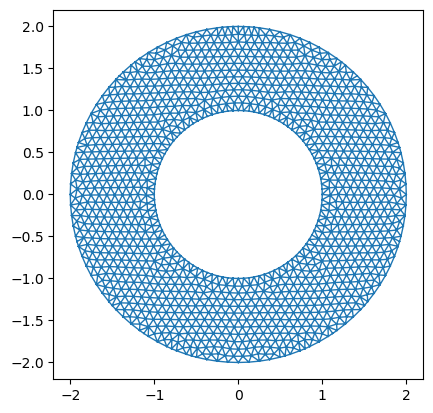

In [3]:
# mesh: annulus with center [0,0], inner radius 1, outer radius 2
# pfix: some points on circles with center [0,0] and radii 2 and 1

def fd(p):
    d1 = dcircle(p,0,0,2)
    d2 = dcircle(p,0,0,1)
    return ddiff(d1,d2)

pfix = put_pts_on_circle(0,0,2,100)
pfix = np.append(pfix, put_pts_on_circle(0,0,1,100), axis=0)
h0 = 0.1
pts, tri = distmesh2D(fd, huniform, h0, [-2, 2, -2, 2], pfix)
Npts = np.size(pts,axis=0)
Ntri = np.size(tri,axis=0)
plt.savefig("hw10 mesh.png")

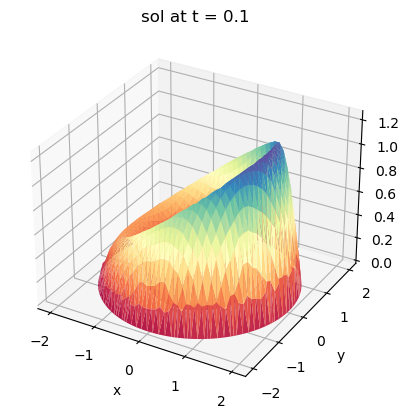

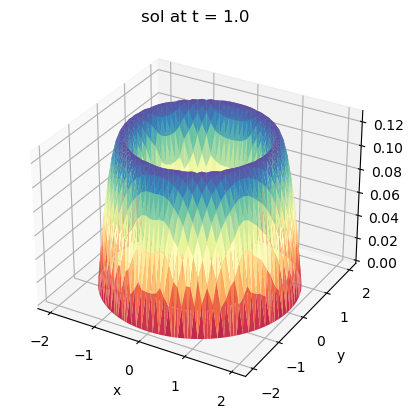

In [4]:
ND0ind, D0ind = find_circle_pts(pts,0,0,1,h0) # find mesh points on r=1
ND1ind, D1ind = find_circle_pts(pts,0,0,2,h0) # find mesh points on r=2

# initial condition: u(t=0) = r+cos(phi)
U = np.zeros((Npts,1))
for j in range(Npts):
    x = pts[j][0]
    y = pts[j][1]
    r = np.sqrt(x**2+y**2)
    phi = np.arctan2(y,x)
    U[j] = r+np.cos(phi)

# iterate U
T = 1
dt = 0.01
N = int(T/dt)
for n in range(N):
    U = FEM_hw_iterator(pts,tri,D0ind,D1ind,dt,U)
    # visualize U at t = 0.1 and t = 1
    t = (n+1)*dt
    if t in [0.1,1]:
        fig = plt.figure(figsize=plt.figaspect(1))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.tick_params(axis='both', labelsize=10)
        ax.plot_trisurf(pts[:,0],pts[:,1],U,cmap=plt.cm.Spectral)
        plt.rcParams.update({'font.size': 10})
        plt.title("sol at t = {}".format(t))
        plt.xlabel("x")
        plt.ylabel("y")
        plt.savefig('hw10 sol t={}.png'.format(t))
        plt.show()

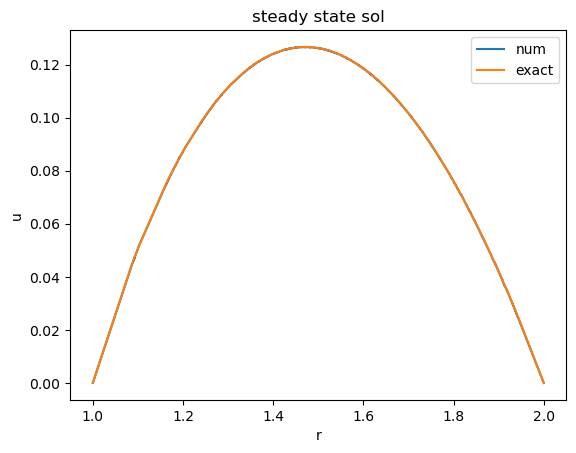

In [5]:
r = np.sqrt(pts[:,0]**2+pts[:,1]**2)
sort = np.argsort(r)
r = r[sort]
plt.plot(r, U[sort], label="num")
plt.plot(r, (1-r**2)/4+3*np.log(r)/(4*np.log(2)), label="exact")
plt.legend()
plt.title("steady state sol")
plt.xlabel("r")
plt.ylabel("u")
plt.savefig("hw10 steady state sol.png")
plt.show()